In [1]:
%load_ext autoreload
%matplotlib inline
from time import time
import os
import numpy as np
import pandas as pd
from icecream import ic as iprint
import matplotlib.pyplot as plt
from typing import Tuple

from torch_geometric.transforms import RandomLinkSplit
import torch
from torch_geometric import seed_everything
from torch.optim import Optimizer
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data as PyGData

import sys
sys.path.append("..")
from recsys.data.lastfm import load_dataset, LastFMDataset
# from recsys.model.egcn import EGCN
from recsys.model.lightgcn import LGCN
from recsys.data.types import DataLoaderConfig
from recsys.utils.sample_negative import sample_negative_edges
from recsys.config import config

seed_everything(5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cpu


# Load LastFM Dataset

In [2]:
%%time

input_file = os.path.join("..", "data", "lastfm_adj.csv")
df = pd.read_csv(input_file)
data, num_user_ids, num_item_ids = load_dataset(df, device)
# iprint(data)

CPU times: user 4.48 s, sys: 212 ms, total: 4.69 s
Wall time: 4.99 s


# Split LastFM Dataset

In [3]:
def train_test_val_split(data: PyGData, config: DataLoaderConfig):
    """Split PyG graph data into training, validation and testing sub-data objects by edges
    :param data: Original PyG graph data
    :param config: Sub-data configuration
    :return: Training, validation and testing PyG graph data objects
    """
    print("| Splitting the graph into train, val and test")
    # Split edges into training, validation and testing datasets,
    # and add reversed edges (item -> user) for message passing
    transform = RandomLinkSplit(
        is_undirected=True,
        add_negative_train_samples=False,
        num_val=config.val_split,
        num_test=config.test_split,
        neg_sampling_ratio=0,
    )
    train_split, val_split, test_split = transform(data)
    iprint(train_split)

    # Confirm that every node appears in every set above
    assert (
        train_split.num_nodes == val_split.num_nodes
        and train_split.num_nodes == test_split.num_nodes
    )
    return train_split, val_split, test_split

In [4]:
def create_dataloaders_generic(config: DataLoaderConfig, data: PyGData) -> Tuple[
    Tuple[LastFMDataset, PyGData],
    Tuple[LastFMDataset, PyGData],
    Tuple[LastFMDataset, PyGData],
]:
    """
    :param config: Configuration for data splitting
    :param data: Original PyG graph data
    :return: Tuples (ground-truth edge data and PyG subgraph data for message passing)
        for training, validation and testing datasets
    """
    train_split, val_split, test_split = train_test_val_split(data, config)

    # Edge data for ground-truth labels (only user -> item edges)
    train_ev = LastFMDataset("temp", edge_index=train_split.edge_label_index)
    # PyG graph object with reversed edges for message passing
    train_mp = PyGData(x=train_split.x, edge_index=train_split.edge_index)
    iprint(train_ev.edge_index.shape)
    iprint(train_mp)

    val_ev = LastFMDataset("temp", edge_index=val_split.edge_label_index)
    val_mp = PyGData(x=val_split.x, edge_index=val_split.edge_index)

    test_ev = LastFMDataset("temp", edge_index=test_split.edge_label_index)
    test_mp = PyGData(x=test_split.x, edge_index=test_split.edge_index)

    return (
        (train_ev, train_mp),
        (val_ev, val_mp),
        (test_ev, test_mp),
    )

In [5]:
dl_conf = DataLoaderConfig(test_split=0.15, val_split=0.15)  # Train:Val:Test = 70:15:15
train_t, val_t, test_t = create_dataloaders_generic(dl_conf, data)

| Splitting the graph into train, val and test


ic| train_split: Data(x=[1980, 2], edge_index=[2, 1810346], edge_label=[905173], edge_label_index=[2, 905173])
ic| train_ev.edge_index.shape: torch.Size([2, 905173])
ic| train_mp: Data(x=[1980, 2], edge_index=[2, 1810346])


In [6]:
num_nodes = num_user_ids + num_item_ids

In [7]:
# Data loader of ground-truth existing (positive) edges
train_loader = DataLoader(train_t[0], batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_t[0], batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_t[0], batch_size=config.batch_size, shuffle=False)

# Training and Testing Process

In [8]:
%autoreload
def train(
    model,  # GNN (EvolveGCN) model
    data_mp: PyGData,  # Message passing edges for multi-scale embedding propagation
    loader: DataLoader,  # DataLoader in batches of supervision/evaluation edges
    opt: Optimizer,  # Optimizer
    num_customers: int,  # Number of user nodes
    num_nodes: int,  # Number of total nodes (users + items)
    device: torch.device,  # Device (CPU or GPU)
):
    total_loss = 0
    total_examples = 0
    model.train()
    i = 0
    for batch in loader:  # positive (existing) edges
        i += 1
        del batch.batch
        del batch.ptr  # delete unwanted attributes
        
        opt.zero_grad()
        # Generate negative (non-existing) edges
        negs = sample_negative_edges(batch, num_customers, num_nodes, device)
        data_mp, batch, negs = data_mp.to(device), batch.to(device), negs.to(device)
        loss = model.calc_loss(data_mp, batch, negs)  # Train and compute loss
        loss.backward()
        opt.step()

        num_examples = batch.edge_index.shape[1]
        total_loss += loss.item() * num_examples
        total_examples += num_examples
    avg_loss = total_loss / total_examples
    return avg_loss

def test(
    model,  # GNN (EvolveGCN) model
    data_mp: PyGData,  # Message passing edges for multi-scale embedding propagation
    loader: DataLoader,  # DataLoader in batches of evaluation edges
    k: int,  # Top-k
    device: torch.device,  # Device (CPU or GPU)
):
    model.eval()
    all_recalls = {}
    with torch.no_grad():
        data_mp = data_mp.to(device)  # Save multi-scale embeddings if save_dir is not None

        # Run evaluation
        for batch in loader:  # Batches of positive (existing) edges
            del batch.batch; del batch.ptr  # delete unwanted attributes
            batch = batch.to(device)
            recalls = model.evaluation(data_mp, batch, k)  # Evaluate model performance
            for customer_idx in recalls:
                assert customer_idx not in all_recalls
            all_recalls.update(recalls)
    recall_at_k = np.mean(list(all_recalls.values()))
    return recall_at_k

# Main Training Loop

In [9]:
%autoreload

input_dim = config.embedding_dim

all_train_losses = list()  # list of (epoch, training loss)
all_val_recalls = list()  # list of (epoch, validation recall@k)
all_train_recalls_lgcn = list()  # list of training recalls in LightGCN
all_train_recalls_egcn = list()  # list of training recalls in EvolveGCN

# Initialize GNN Model
gnn = LGCN(
    embedding_dim=input_dim,
    num_nodes=num_nodes,
    num_users=num_user_ids,
    num_layers=config.num_layers,
).to(device)

opt = torch.optim.Adam(gnn.parameters(), lr=config.lr)  # using Adam optimizer

st = time()
for epoch in range(config.epochs):
    train_loss = train(gnn, train_t[1], train_loader, opt, num_user_ids, num_nodes, device)
    all_train_losses.append((epoch, train_loss))
    val_recall = test(gnn, val_t[1], val_loader, config.k, device)
    all_val_recalls.append((epoch, val_recall))
    all_train_recalls_lgcn.append(val_recall)
    tm = time() - st
    print(f"Epoch {epoch}: train loss={train_loss:.6f}, val_recall={val_recall:.6f}, Time: {tm:.2f}[s]")

/opt/homebrew/lib/python3.9/site-packages/torch_geometric/data/storage.py:261: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0: train loss=0.692466, val_recall=0.001784, Time: 10.62[s]
Epoch 1: train loss=0.692415, val_recall=0.001796, Time: 21.45[s]
Epoch 2: train loss=0.692359, val_recall=0.001773, Time: 32.16[s]
Epoch 3: train loss=0.692305, val_recall=0.001726, Time: 42.21[s]
Epoch 4: train loss=0.692242, val_recall=0.001870, Time: 52.49[s]


In [10]:
%%time
# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key=lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
test_recall = test(gnn, test_t[1], test_loader, config.k, device)
print(f"Test set recall@k: {test_recall}")

Best validation recall@k: 0.0018703667644613534 at epoch 4
Test set recall@k: 0.0009241168913701247
CPU times: user 5.64 s, sys: 958 ms, total: 6.6 s
Wall time: 3.53 s


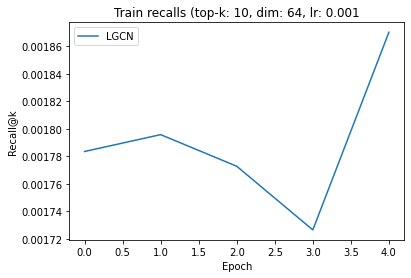

In [13]:
all_epochs = list(range(len(all_train_recalls_lgcn)))
plt.plot(all_epochs, all_train_recalls_lgcn, label="LGCN")
plt.xlabel("Epoch")
plt.ylabel("Recall@k")
# plt.plot(all_epochs, all_train_recalls_egcn, label="EGCN")
plt.title(f"Train recalls (top-k: {config.k}, dim: {input_dim}, lr: {config.lr}")
plt.legend()
plt.show()